<a href="https://colab.research.google.com/github/HwangSiyeon/ESAA_homework/blob/main/ESAA_HW_0316_ImputingNA%2CBoxCox_StackedRegressions_KagglePractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stacked Regressions to predict House Price

In [80]:
# import some necessary libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
  pass
warnings.warn = ignore_warn # ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew # for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # Limiting floats output to 3 decimal points

from subprocess import check_output
# print(check_output(["ls","../input"]).decode("utf8")) # check the files available in the directory

In [81]:
# Now let's import and put the train and test datasets in  pandas dataframe
train = pd.read_csv('/content/drive/MyDrive/ESAA_OB_HW/DATA/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA_OB_HW/DATA/test.csv')

In [82]:
## display the first five rows of the train dataset
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [83]:
##display the first five rows of the test dataset

test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [84]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {}".format(train.shape))
print("The test data size before dropping Id feature is : {}".format(test.shape))

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape))
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81)
The test data size before dropping Id feature is : (1459, 80)

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


- ID 테이블을 삭제한 후 feature이 하나 줄었다.

## Data Processing

### Outliers

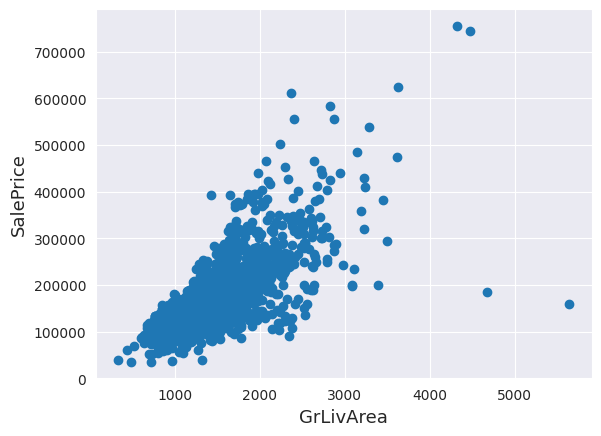

In [85]:
fig,ax = plt.subplots()
ax.scatter(x = train["GrLivArea"], y = train["SalePrice"])
plt.ylabel("SalePrice", fontsize=13)
plt.xlabel("GrLivArea", fontsize=13)
plt.show()

- 우측 아래의 2개의 outlier가 보이다.

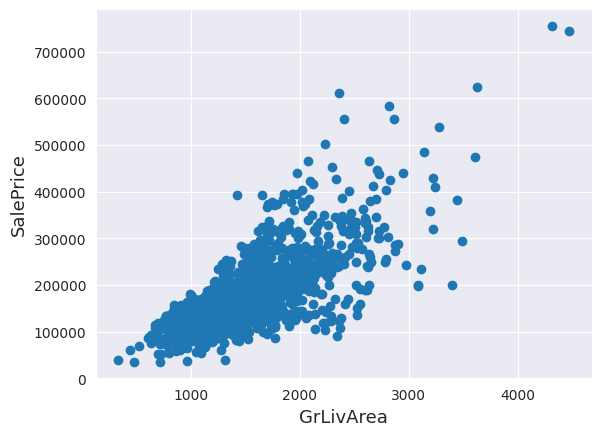

In [86]:
# Deleting outliers
train = train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index)

# Check the graphic again
fig,ax = plt.subplots()
ax.scatter(x = train["GrLivArea"], y = train["SalePrice"])
plt.ylabel("SalePrice", fontsize=13)
plt.xlabel("GrLivArea", fontsize=13)
plt.show()


 mu = 180932.92 and sigma = 79467.79



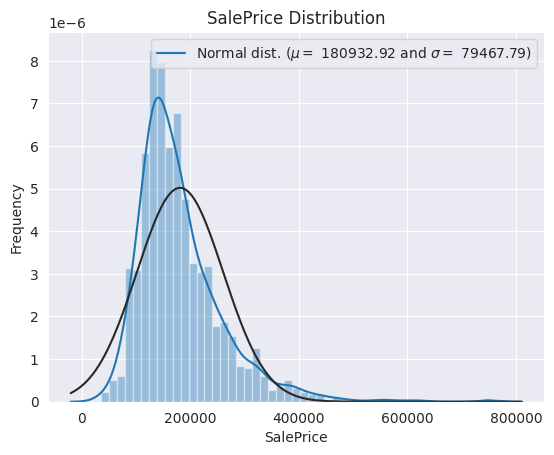

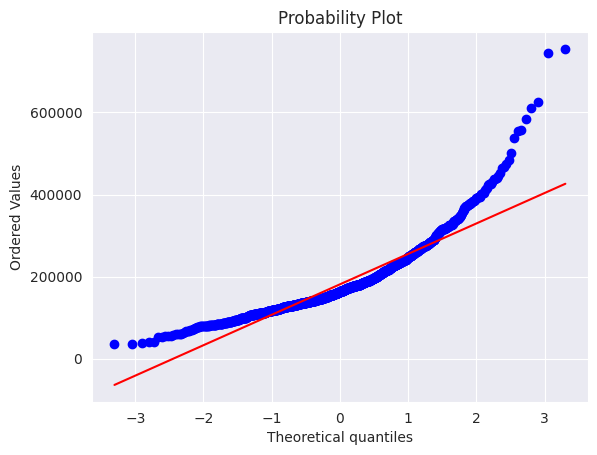

In [87]:
sns.distplot(train["SalePrice"], fit = norm)

# Get the fitted parameters used bu the function
(mu,sigma) = norm.fit(train["SalePrice"])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))

# Now plot the distribution
plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)], loc="best")
plt.ylabel('Frequency')
plt.title("SalePrice Distribution")

# Get also the QQ-Plot
fig = plt.figure()
res = stats.probplot(train["SalePrice"], plot = plt)
plt.show()

- 타겟값이 right-skewed 됨을 알 수 있다. 타겟값을 정규분포에 근사하도록 해야 linear model이 모델을 잘 적합할 수 있다.


 mu = 12.02 and sigma = 0.40



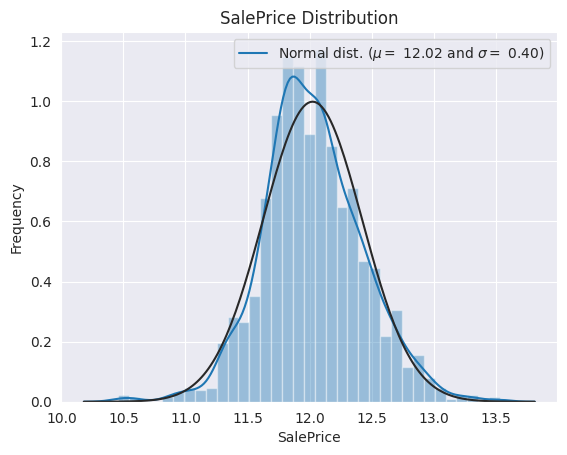

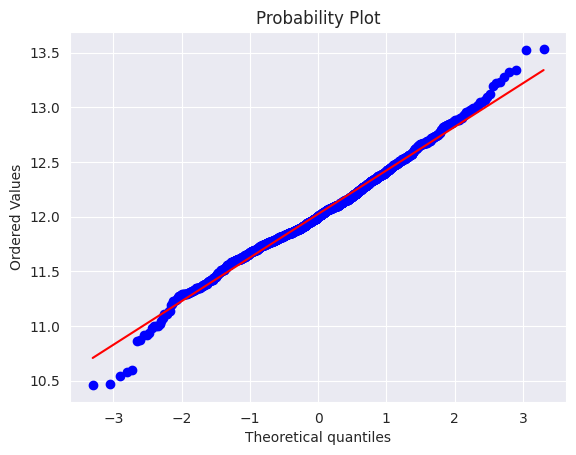

In [88]:
# We use the numpy function log1p which applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

# Check the new districution
sns.distplot(train["SalePrice"], fit=norm)

# Get the fitted parameters used by the function
(mu,sigma) = norm.fit(train["SalePrice"])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu,sigma))

# Now plot the distribution
plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)], loc="best")
plt.ylabel('Frequency')
plt.title("SalePrice Distribution")

# Get also the QQ-Plot
fig = plt.figure()
res = stats.probplot(train["SalePrice"], plot = plt)
plt.show()

- 데이터가 정규분포에 가까워짐을 알 수 있다

### Features Engineering
- Train데이터와 Test 데이터를 같은 데이터프레임에 concat한다

In [89]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop(["SalePrice"], axis=1, inplace = True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


#### Missing Data

In [90]:
all_data_na = (all_data.isnull().sum())/len(all_data)*100  # column별 NA비율
all_data_na = all_data_na.drop(all_data_na[all_data_na ==0].index).sort_values(ascending = False)[:30] # 모든 column이 0인 열 dropg후 NA 비율 적은 순서로 배열
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na}) # "Missing Ration"라는 column 아래에 all_data_na를 데이터 프레임화
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent of missing data by feature')

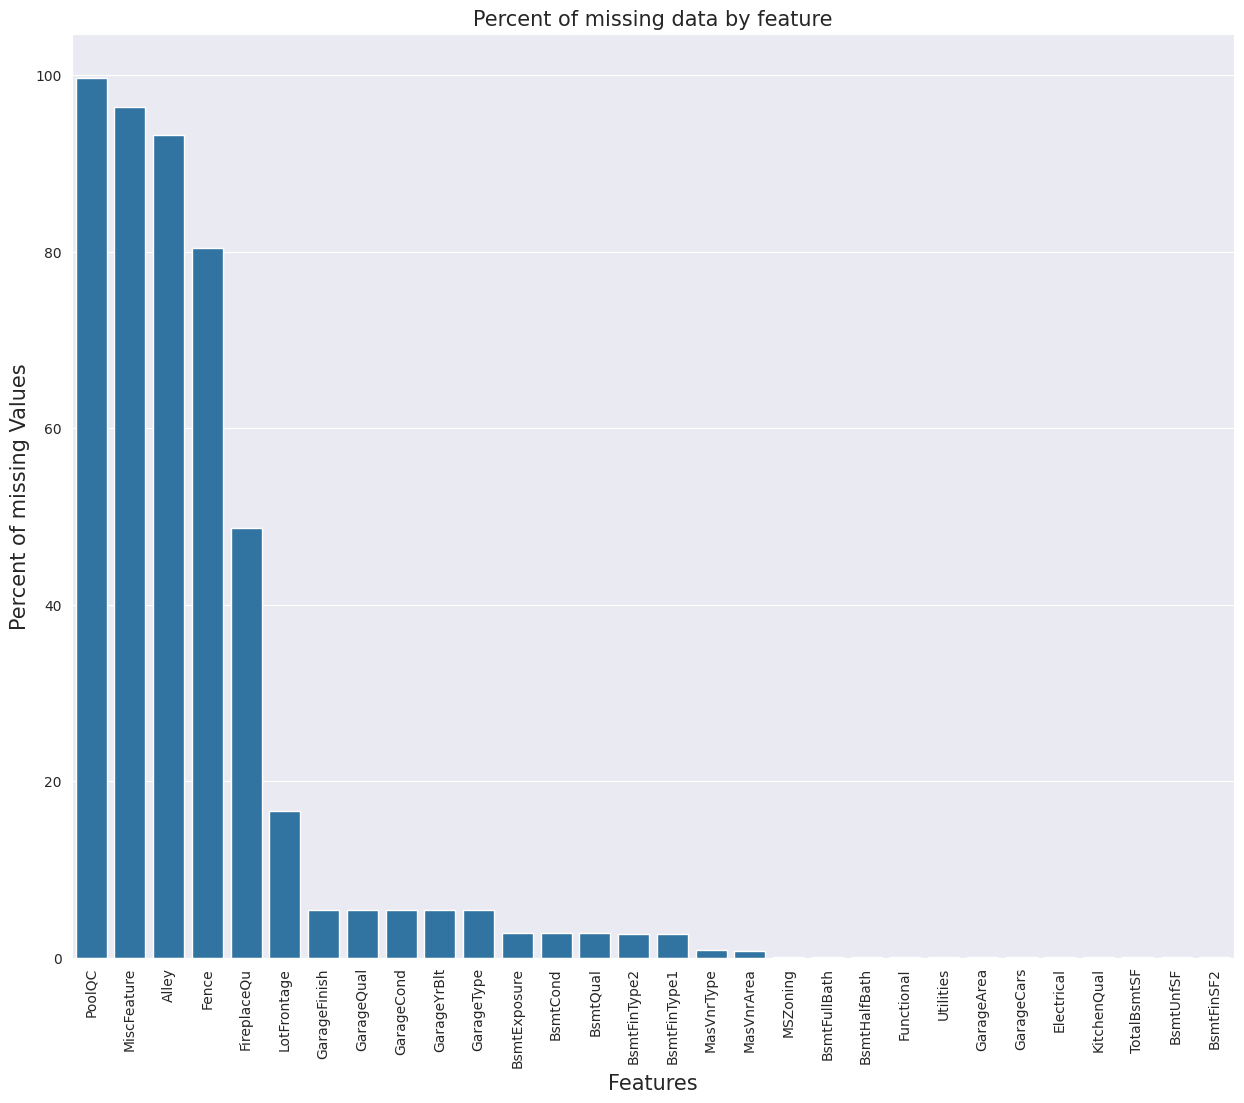

In [91]:
f,ax = plt.subplots(figsize = (15,12))
plt.xticks(rotation = 90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel("Features", fontsize=15)
plt.ylabel("Percent of missing Values", fontsize=15)
plt.title("Percent of missing data by feature", fontsize=15)

<Axes: >

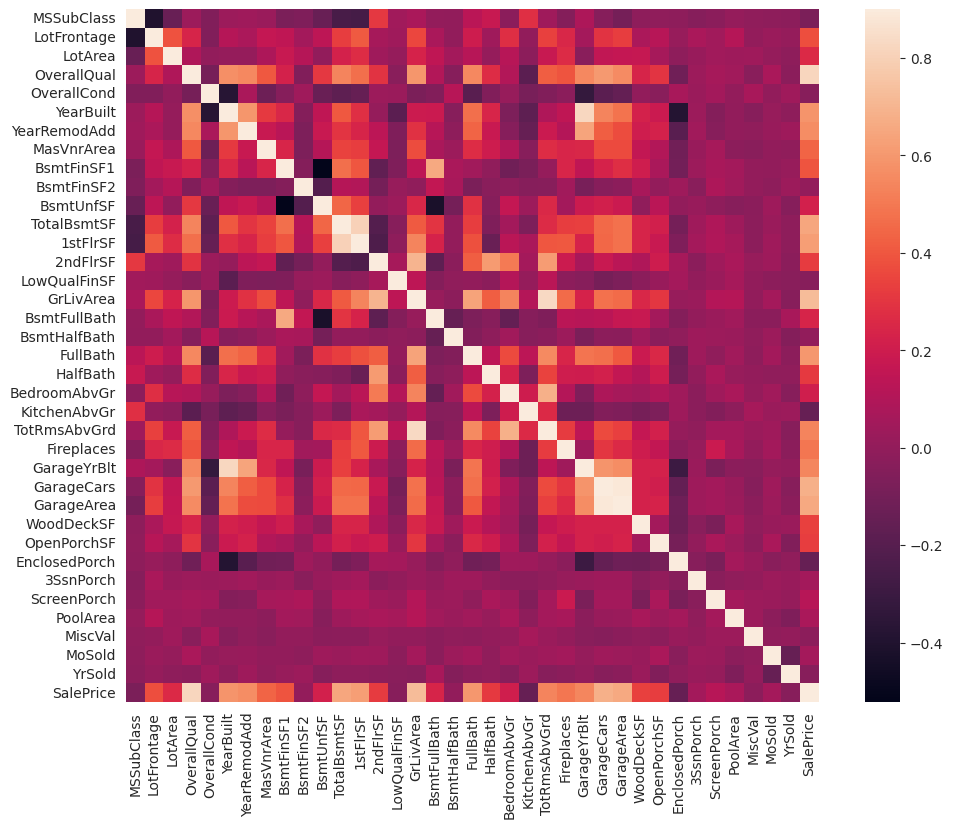

In [92]:
# Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

#### Imputing missing values(결측값 대체)
- PoolQC: 데이터 설명에 따르면 NA는 "수영장 없음"을 의미한다. 이는 결측값의 비율이 매우 높고 대부분의 집이 일반적으로 전혀 수영장이 없기 때문에 타당하다.
- MiscFeature: NA는 "기타 기능 없음"을 의미한다.
= Alley: NA는 "골목,거리 접근 불가"를 의미한다.
- Fence : NA는 "울타리 없음"을 의미한다.
= FireplaceQu : NA는 "벽난로 없음"을 의미한다.
















In [93]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- 부동산 부지 면적은 해당 지역의 다른 집들과 유사할 가능성이 높기 때문에, 결측값은 해당 동네의 LotFrontage의 중앙값으로 채울 수 있다.








In [94]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x : x.fillna(x.median()))

- GarageType, GarageFinish, GarageQual and GarageCond : 결측치를 "None"으로 대체한다


In [95]:
for col in ("GarageType", "GarageFinish", "GarageQual","GarageCond"):
  all_data[col] = all_data[col].fillna("None")

- GarageYrBlt, GarageArea and GarageCars : 결측치를 0으로 대체한다. 차고가 없다 = 차가 없다 (Since No garage = no cars in such garage.)


In [96]:
for col in  ("GarageYrBlt", "GarageArea" ,"GarageCars"):
  all_data[col] = all_data[col].fillna(0)

- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath :지하실이 없으면 NaN들은 "None"이다




In [97]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : NaN은 지하실이 없음("None")을 의미


In [98]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- MasVnrArea and MasVnrType : NA는 masonry veneer가 해당 집에 없음을 의미. 다음 값들을 0으로 대체 가능하다


In [99]:
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")

- MSZoning (The general zoning classification) : 'RL' 은 아주 흔한 값이다. NA를 'RL'으로 대체한다


In [100]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0]) # mode는 최빈값

- Utilities: 이 범주형 특성에서 1개의 "NoSeWa"와 2개의 NA를 제외하고 모든 레코드는 "AllPub"이다. 'NoSewa'를 갖는 집이 Train 데이터셋에 있으므로, 이 feature는 예측 모델링에 도움이 되지 않을 것이다.그러므로 제거해도 무방하다.









In [101]:
all_data = all_data.drop(['Utilities'], axis=1)

- Functional : 데이터 설명서에 의하면 NA는 "Typ"을 의미

In [102]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- Electrical : 1개의 NA 값이 있다. 이 feature는 대부분'SBrkr'이므로, NA 를 'SBrkr'로 대체한다
- KitchenQual: NA 값이 하나뿐이다. Electrical과 마찬가지로 KitchenQual의 결측값을 가장 빈도가 높은 값인 'TA'로 대체한다.
- KitchenQual :  Exterior 1 및 2에는 결측값이 하나씩만 있다. 가장 빈도가 높은 문자열으로 대체한다.
- SaleType : 결측값을 가장 빈도가 높은 "WD"로 대체한다.

In [103]:
all_data["Electrical"] = all_data["Electrical"].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- MSSubClass :  "No building class"를 의미할 확률이 높다. "None"으로 대체


In [104]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

- 결측치가 더 남아있는지 확인해본다

In [105]:
#Check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


- 결측치가 더이상 없다

#### Transforming some numerical variables that are really categorical
- Numeric으로 보이지만 사실은 categorical인 변수들 타입 변환



In [106]:
# MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


# Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### Label Encoding some categorical variables that may contain information in their ordering set

In [107]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond',
        'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence',
        'BsmtExposure', 'GarageFinish', 'LandSlope','LotShape', 'PavedDrive', 'Street', 'Alley',
        'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
  lbl = LabelEncoder()
  lbl.fit(list(all_data[c].values))
  all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


#### Adding one more important feature
- 지하실, 1층, 2층 면적의 총 합에 대한 변수 추가

In [108]:
# Adding total sqfootage feature
all_data["TotalSF"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"]

#### Skewed features

In [109]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features:\n")
skewness = pd.DataFrame({"Skew" : skewed_feats})
skewness.head(10)


Skew in numerical features:



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


#### Box Cox Transformation of (highly) skewed features
- 왜도가 높은 변수들에 Box-Cox 변환(1+x)

In [110]:
skewness = skewness[abs(skewness) > 0.75]  # 왜도가 0.75 이상인 변수들
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


#### Getting dummy categorical features
- pd.get_dummies로 one-hot encoding


In [111]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [112]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Modelling¶

#### Import librairies


In [113]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

#### Define a cross validation strategy
- sklearn에서 cross_val_score 을 사용


In [114]:
# Validation Function
n_folds = 5

def rmsle_cv(model):
  kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(train.values)
  rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
  return(rmse)


### Base Models

#### Lasso Regression
- 이 모델은 outlier에 예민하다. 따라서 sklearn에서 RobustScaler()함수를 이용해 더욱 모델을 견고하게 만들어야 한다.

In [115]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state =1))

#### ElasticNet Regression
- Lasso처럼 outlier에 견고하게 만들어야 한다

In [116]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#### Kernel Ridge Regression

In [117]:
KRR = KernelRidge(alpha=0.6, kernel = 'polynomial', degree=2, coef0 = 2.5)

#### Gradient Boosting Regression
- 아웃라이어에 강한 휴버 손실(Huber Loss)을 사용하여 견고하게 만든다.







In [118]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)

#### XGBoost


In [119]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3,  min_child_weight=1.7817,
                             n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1,random_state =7, nthread = -1)

#### LightGBM

In [120]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base models scores

In [121]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)

ElasticNet score: 0.1116 (0.0074)

Kernel Ridge score: 0.1153 (0.0075)

Gradient Boosting score: 0.1167 (0.0083)

Xgboost score: 0.1162 (0.0078)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 wil

### Stacking models

#### Average Base Model

In [122]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
  def __init__(self, models):
    self.models = models

  # 데이터를 fitting 하기 위해 원본 모델의 클론을 정의한다.
  def fit(self, X, y):
    self.models_ = [clone(x) for x in self.models]

    # 원본 모델의 클론모델을 피팅한다
    for model in self.models_:
      model.fit(X, y)
      return self

  # 클론모델로 prediction 후 평균을 구한다.
  def predict(self, X):
    predictions = np.column_stack([model.predict(X) for model in self.models_])
    return np.mean(predictions, axis=1)

- 정의한 함수를 이용해 위에서 정의한 릿지, 라쏘, 엘라스틱넷, 그라디언트부스팅을 평균한다

In [123]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1087 (0.0077)



- 스태킹이 예측결과를 더 나아지게 함을 알 수 있다

### Less simple Stacking : Adding a Meta-model

In [124]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
  def __init__(self, base_models, meta_model, n_folds=5):
    self.base_models = base_models
    self.meta_model = meta_model
    self.n_folds = n_folds

  # We again fit the data on clones of the original models
  def fit(self, X, y):
    self.base_models_ = [list() for x in self.base_models]
    self.meta_model_ = clone(self.meta_model)
    kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

    # Train cloned base models then create out-of-fold predictions
    # that are needed to train the cloned meta-model
    out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
    for i, model in enumerate(self.base_models):
      for train_index, holdout_index in kfold.split(X, y):
        instance = clone(model)
        self.base_models_[i].append(instance)
        instance.fit(X[train_index], y[train_index])
        y_pred = instance.predict(X[holdout_index])
        out_of_fold_predictions[holdout_index, i] = y_pred

     # Now train the cloned  meta-model using the out-of-fold predictions as new feature
    self.meta_model_.fit(out_of_fold_predictions, y)
    return self

  #Do the predictions of all base models on the test data and use the averaged predictions as
  #meta-features for the final prediction which is done by the meta-model
  def predict(self, X):
    meta_features = np.column_stack([np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
                                      for base_models in self.base_models_ ])
    return self.meta_model_.predict(meta_features)

In [125]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model = lasso)
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


#### Ensembling StackedRegressor, XGBoost and LightGBM


In [126]:
def rmsle(y, y_pred):
  return np.sqrt(mean_squared_error(y, y_pred))

#### Final Training and Prediction



In [127]:
#### StackedRegressor
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

### XGBoost
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

### LightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

### RMSE on the entire Train data when averaging
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

### Ensemble prediction:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

### Submission
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

0.07839506096665937
0.08632034929442625
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM